# **Recommendations systems on MovieLens**

### Introduction

`Recommender systems` are used in all current online service companies, helping both the company and the user to receive content that they are interested in.


In this project, I am going to explore the implementation of different types of recommender systems using the MovieLens dataset provided by 'The Department of Computer Science and Engineering at the University of Minnesota' and that we can find in: https://grouplens.org/datasets/movielens/ 

I start the project with a data cleaning aimed at removing all unused features and duplicate data and I deal with missing data that I get by using scraping techniques. In addition, I added new features in order to make the data set richer and capture more complex patterns.
Next, I perform an exploratory data analysis in which we can get an idea of how the data is distributed using both visual and probabilistic techniques.

Finally, I develop a **content-based recommender**, which utilizes movie attributes to suggest similar movies and also a **collaborative filtering recommender** based on user-movies interaction matrix.

## **0. Import main libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## **1. Load data sets**

First, we need to download the data. As we want to work with the latest data set, we download it directly from the oficial site:

In [2]:
!curl http://files.grouplens.org/datasets/movielens/ml-latest-small.zip -o ml-latest-small.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  2  955k    2 23083    0     0  22404      0  0:00:43  0:00:01  0:00:42 22476
 54  955k   54  520k    0     0   264k      0  0:00:03  0:00:01  0:00:02  264k
100  955k  100  955k    0     0   432k      0  0:00:02  0:00:02 --:--:--  433k


We have to extract the data from the .zip file:

In [3]:
import zipfile
with zipfile.ZipFile('ml-latest-small.zip','r') as zip_:
    zip_.extractall('data')

Finally, we can load the data sets:

In [4]:
movies_df = pd.read_csv('./data/ml-latest-small/movies.csv')
ratings_df = pd.read_csv('./data/ml-latest-small/ratings.csv')

## **2. Data Cleaning and feature engineering**

In this section, we are dealing with empty cells and duplicates in our data as well as some preprocessing of our data. 

Let's have a look at the data:

In [5]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


We can see that each row contains the 'movieId' (that will be essential to relation the two data sets), the 'title' and the 'genres'. This data frame give us information solely about the movies.

With this data we could do a really basic clustering classifying films by genres, but we are going to improve the data set by adding new features.

The data frame is sort by the 'movieId' (also 'year' and 'genres' in that order) and the bijection 'movieid' - 'movie' seems to be increasing in year with exceptions.

In [80]:
ratings_df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


Here, we can already see that we are going to work with relational datasets, since to know the details of the movie 'i' (to which the user 'j' gave a score of 4) we have to resort to the other table.

In this dataframe we have implicitly an `user-item interactions matrix` given in its sparse form by 'userId', 'movieId' and 'rating'. 

We can also observe the df is sort by 'userId' and 'movieId', in that order.

### **Null values, duplicates and unrated movies**

In [7]:
print(movies_df.info())
print(ratings_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None


It does not seem the data has null values.

Let's see if we have duplicates in our data (we just have to do this with the movies titles):

In [8]:
print('We have {} movies that are duplicate'.format(movies_df['title'].duplicated().sum()))

We have 5 movies that are duplicate


Let's find out which one are:

In [9]:
duplicate = movies_df[movies_df['title'].duplicated() == True]
duplicate

,movieId,title,genres
5601,26958,Emma (1996),Romance
6932,64997,War of the Worlds (2005),Action|Sci-Fi
9106,144606,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Romance|Thriller
9135,147002,Eros (2004),Drama|Romance
9468,168358,Saturn 3 (1980),Sci-Fi|Thriller


In [10]:
duplicate_movieId = list(duplicate.movieId)
duplicate_movie_index = list(duplicate.index)
ratings_duplicate_movies = ratings_df[ratings_df['movieId'].isin(duplicate_movieId)]

In [11]:
ratings_df.drop(ratings_duplicate_movies.index, inplace = True)
movies_df.drop(duplicate.index, inplace = True)
print('We have {} movies that are duplicate'.format(movies_df['title'].duplicated().sum()))

We have 0 movies that are duplicate


Last but not least, we have to eliminate the movies that have not any rating:

In [12]:
print('We have {} movies but only {} are rated'.format(movies_df['movieId'].nunique(),ratings_df['movieId'].nunique()))

We have 9737 movies but only 9719 are rated


In [13]:
no_rated = set(movies_df['movieId']) - set(ratings_df['movieId'])
no_info = set(ratings_df['movieId']) - set(movies_df['movieId']) #this happens to be the empty set, so we have not got movies without information
no_rated_index = movies_df[movies_df['movieId'].isin(no_rated)].index
movies_df.drop(no_rated_index, inplace = True)

In [14]:
print('We have {} movies and {} are rated.'.format(movies_df['movieId'].nunique(),ratings_df['movieId'].nunique()))

We have 9719 movies and 9719 are rated.


### **Release Year**

Now, at the movies_df, we want to separate the title and the year. We are needing the module re to manage regular expressions: 

In [15]:
import re

As the year is the last number in the string 'title', we define the following function:

In [16]:
def find_year (title):
    try:
        numbers = re.findall(r'\(\d+\)', title)
        year = numbers[len(numbers)-1]
        year = re.sub(r'[\(\)]','',year)
        year = int(year)
    except:
        year = None
    return year

In [17]:
years = movies_df['title'].apply(lambda x: find_year(x))

#We are going to work with a copy of movies_df to modify the values
movies = movies_df.copy()
movies['year'] = years

In [18]:
movies['year'].info()

<class 'pandas.core.series.Series'>
Index: 9719 entries, 0 to 9741
Series name: year
Non-Null Count  Dtype  
--------------  -----  
9706 non-null   float64
dtypes: float64(1)
memory usage: 151.9 KB


We can observe 10 movies have no year of release. Although there is not much data left and we are not going to work much with the `year` column, it is a good exercise to obtain the year of release using `requests` and `bs4`:

In [19]:
null_year_movies = movies[movies['year'].isnull()]
null_year_movies

,movieId,title,genres,year
6059,40697,Babylon 5,Sci-Fi,NaN
9031,140956,Ready Player One,Action|Sci-Fi|Thriller,NaN
9091,143410,Hyena Road,(no genres listed),NaN
9138,147250,The Adventures of Sherlock Holmes and Doctor W...,(no genres listed),NaN
9179,149334,Nocturnal Animals,Drama|Thriller,NaN
9259,156605,Paterson,(no genres listed),NaN
9367,162414,Moonlight,Drama,NaN
9448,167570,The OA,(no genres listed),NaN
9514,171495,Cosmos,(no genres listed),NaN
9515,171631,Maria Bamford: Old Baby,(no genres listed),NaN


Let's try to collect the release year for a particular movie and then we will modify and adapt the function to our data

In [20]:
import requests
from bs4 import BeautifulSoup
import urllib.parse

movie = 'Interestellar'

#As I have the computer in my native language, the results are in spanish:
query = f"{movie} fecha estreno"


url = "https://www.google.com/search?q=" + urllib.parse.quote(query)
#https://www.google.com/search?q=Interestellar%20fecha%20de%20estreno

#If we do not specify the headers, google does not allow us to request becuase it is prepare to avoid BOTS:
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

response = requests.get(url, headers=headers)

soup = BeautifulSoup(response.text, "html.parser")

#We try to find the year:
try:
    date = soup.find('div', class_="EfDVh wDYxhc NFQFxe viOShc LKPcQc").text  #we have find this route using 'Inspect' in Google
    for i in re.findall(r'\d+',date):
                if len(i) == 4: #the lenght of a year suppose to be 4
                    date = i
                    break
except:
    date = 0000

print('The release year of {} is {}'.format(movie, date))

The release year of Interestellar is 2014


Now we define the function and we modify it to fit the data. We have to know that scraping is not something precise, and it can vary with search engines like Google. That is why we add so many try and except in the code:

In [21]:
def obtain_release_year(movie):
    query = f"{movie} pelicula fecha estreno"
    url = "https://www.google.com/search?q=" + urllib.parse.quote(query)
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }
    
    response = requests.get(url, headers=headers)
    
    soup = BeautifulSoup(response.text, "html.parser")

    date = None

    #Now we try with some common class that we found with 'Inspect':
    
    try:
        date = soup.find('div', class_="EfDVh wDYxhc NFQFxe viOShc LKPcQc").text
        
    except:
        
        try:
            date = soup.find('div', class_="iAIpCb PZPZlf").text
        except:
            pass
            
    finally:
        try:
            for i in re.findall(r'\d+',date):
                    if len(i) == 4:
                        date = int(i)
                        break
        except:
            print('We did not find the date, here is the url: {}'.format(url))
    print('The release year of {} is {}'.format(movie, date))
    return date

Finally, we obtain the dates for our movies:

In [22]:
null_year_movies.loc[:, 'year'] = null_year_movies['title'].apply(lambda x: obtain_release_year(x))

The release year of Babylon 5 is 1994
The release year of Ready Player One is 2018
The release year of Hyena Road is 2015
The release year of The Adventures of Sherlock Holmes and Doctor Watson is 1980
The release year of Nocturnal Animals is 2016
The release year of Paterson is 2016
The release year of Moonlight is 2016
The release year of The OA is 2016
We did not find the date, here is the url: https://www.google.com/search?q=Cosmos%20pelicula%20fecha%20estreno
The release year of Cosmos is None
The release year of Maria Bamford: Old Baby is 2017
We did not find the date, here is the url: https://www.google.com/search?q=Death%20Note%3A%20Desu%20n%C3%B4to%20%282006%E2%80%932007%29%20pelicula%20fecha%20estreno
The release year of Death Note: Desu nôto (2006–2007) is None
The release year of Generation Iron 2 is 2017
The release year of Black Mirror is 2011


We still having a problem with 'Cosmos' and 'Death Note: Desu nôto (2006–2007)'. We are going to suppose it is 'Pretty Guardian Sailor Moon Cosmos' and 'Death Note Movie' and we change the names:

In [23]:
null_year_movies.loc[null_year_movies['title'] == 'Cosmos', 'title'] = 'Pretty Guardian Sailor Moon Cosmos'
null_year_movies.loc[null_year_movies['title'] == 'Death Note: Desu nôto (2006–2007)', 'title'] = 'Death Note Movie'

In [24]:
null_year_movies.loc[null_year_movies['title'] == 'Pretty Guardian Sailor Moon Cosmos', 'year'] = obtain_release_year('Pretty Guardian Sailor Moon Cosmos')
null_year_movies.loc[null_year_movies['title'] == 'Death Note Movie', 'year'] = obtain_release_year('Death Note Movie')

The release year of Pretty Guardian Sailor Moon Cosmos is 2023
The release year of Death Note Movie is 2006


We just have to modify the values of the dataframe `movies` and verify:

In [25]:
movies.loc[movies['movieId'].isin(list(null_year_movies.movieId))] = null_year_movies
movies.year = movies.year.astype(int)
movies.year.info()

<class 'pandas.core.series.Series'>
Index: 9719 entries, 0 to 9741
Series name: year
Non-Null Count  Dtype
--------------  -----
9719 non-null   int32
dtypes: int32(1)
memory usage: 113.9 KB


We can remove the year in the `title` column and clean the string:

In [26]:
movies['title'] = movies['title'].apply(lambda x: re.sub(r'\(\d+\)','',x))
movies['title'] = movies['title'].str.strip() 

Now we have the problem that maybe different movies in "movies_df" have now the same title because we eliminated the year.

In [27]:
print('There are {} movies in "movies" but only {} are unique'.format(len(movies['title']),movies['title'].nunique()))
print('By contrast, there are {} movies in "movies" and {} are unique'.format(len(movies_df['title']),movies_df['title'].nunique()))
print('But we have {} movies with same title and year'.format(len(movies[movies.duplicated(subset=['title','year'], keep=False)])))

There are 9719 movies in "movies" but only 9446 are unique
By contrast, there are 9719 movies in "movies" and 9719 are unique
But we have 0 movies with same title and year


As they are index by `movieId`,we have no problem.

In [28]:
#And finally put the new features into 'movies_df':
movies_df['title'] = movies['title']
movies_df['year'] = movies['year']

### **Genres**

In order to future studies, we are going to **store the genres** of each movie **as a list and** also **as a string of lowercase words**:

In [29]:
print(movies_df.loc[movies_df['genres'] == '(no genres listed)'].head())
print('There is {} elements without genres information'.format(len(movies_df.loc[movies['genres'] == '(no genres listed)'])))

      movieId                                             title  \
8517   114335                                        La cravate   
8684   122888                                           Ben-hur   
8687   122896  Pirates of the Caribbean: Dead Men Tell No Tales   
8782   129250                                        Superfast!   
8836   132084                                      Let It Be Me   

                  genres  year  
8517  (no genres listed)  1957  
8684  (no genres listed)  2016  
8687  (no genres listed)  2017  
8782  (no genres listed)  2015  
8836  (no genres listed)  1995  
There is 34 elements without genres information


We could take the information using `bs4` and `requests` again, but we are going to leave it like this. Let's check the null values:

In [30]:
movies_df.loc[movies_df['genres'].isnull()]

,movieId,title,genres,year


There are not null values. Let's change the format:

In [31]:
movies_df['genres'] = movies_df['genres'].apply(lambda x: x.split('|'))
movies_df['genres_str'] = movies_df['genres'].apply(lambda x: ' '.join(x))

### **TimeStamp**

We are not really working with the timestamp, so we are going to drop it:

In [32]:
ratings_df.drop('timestamp', axis = 1, inplace= True)

## **3. Exploratory analysis**

Until here, our data frames look like:

In [33]:
movies_df.head()

,movieId,title,genres,year,genres_str
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,Adventure Animation Children Comedy Fantasy
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995,Adventure Children Fantasy
2,3,Grumpier Old Men,"[Comedy, Romance]",1995,Comedy Romance
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995,Comedy Drama Romance
4,5,Father of the Bride Part II,[Comedy],1995,Comedy


In [34]:
ratings_df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


### **Ratings analysis and 'popularity'**

The ratings can be view as a sample that come from a **discrete** population which takes values between 0.5 and 5:

count    100830.000000
mean          3.501567
std           1.042548
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


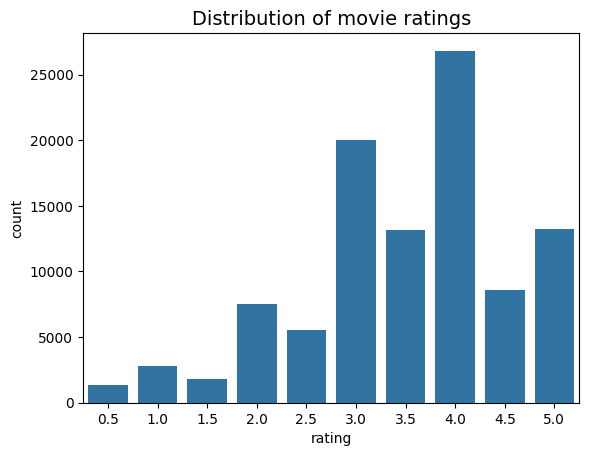

In [35]:
print(ratings_df.rating.describe())
sns.countplot(x="rating", data=ratings_df)
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

We can observe most of the rating are positive (if we mean 'positive' $\geq$  2.75) and integer.

#### Which are the **most voted movies**?

First of all, we are using the map between movieId and title:

In [36]:
movie_names = movies_df.set_index('movieId')['title'].to_dict()

Now we can define `movies_rating_count`:

In [37]:
movies_rating_count = pd.DataFrame(ratings_df.groupby('movieId')['rating'].count()) #we create the 'movie_rating' indexed by 'movieId'
movies_rating_count.index.name = 'movieId' #we change the name
movies_rating_count = movies_rating_count.rename(columns={'rating': 'rating_count'})
movies_rating_count['title'] = movies_rating_count.index.map(movie_names) #we map the names using the dict 'movie_names'
movies_rating_count

,rating_count,title
movieId,,
1,215,Toy Story
2,110,Jumanji
3,52,Grumpier Old Men
4,7,Waiting to Exhale
5,49,Father of the Bride Part II
...,...,...
193581,1,Black Butler: Book of the Atlantic
193583,1,No Game No Life: Zero
193585,1,Flint


Let's sort by `rating_count`:

In [38]:
movies_rating_count = movies_rating_count.sort_values(by = 'rating_count',ascending = False) #we sort
print('The top 10 most voted movies are: ')
movies_rating_count.head(10)

The top 10 most voted movies are: 


,rating_count,title
movieId,,
356,329,Forrest Gump
318,317,"Shawshank Redemption, The"
296,307,Pulp Fiction
593,279,"Silence of the Lambs, The"
2571,278,"Matrix, The"
260,251,Star Wars: Episode IV - A New Hope
480,238,Jurassic Park
110,237,Braveheart
589,224,Terminator 2: Judgment Day


The output seems to be correct because the movies that appear are very popular. We can also see all films are before the 2000's, so probably the ratings were made quite some time ago.

#### Which are the **best voted movies**?

Let's search for the best voted movies looking by the mean of the votes:

In [39]:
movies_rating_mean = pd.DataFrame(ratings_df.groupby('movieId')['rating'].mean())
movies_rating_mean.index.name = 'movieId' #we change the name
movies_rating_mean = movies_rating_mean.rename(columns={'rating': 'rating_mean'})

#Now we do the same as we did with 'movie_rating_count':
movies_rating_mean['title'] = movies_rating_mean.index.map(movie_names) #we map the names using the dict 'movie_names'
movies_rating_mean = movies_rating_mean.sort_values(by = 'rating_mean', ascending = False) #we sort
print('"Supposedly", the top 10 best movies are: ')
movies_rating_mean.head(10)

"Supposedly", the top 10 best movies are: 


,rating_mean,title
movieId,,
126088,5.0,A Flintstones Christmas Carol
145994,5.0,Formula of Love
6192,5.0,Open Hearts (Elsker dig for evigt)
876,5.0,Supercop 2 (Project S) (Chao ji ji hua)
40491,5.0,"Match Factory Girl, The (Tulitikkutehtaan tyttö)"
143031,5.0,Jump In!
143511,5.0,Human
6086,5.0,"I, the Jury"
143559,5.0,L.A. Slasher


However, if we look at the votes per movie:

In [40]:
movies_rating_count[movies_rating_count.index.isin(list(movies_rating_mean.head(10).index))]

,rating_count,title
movieId,,
876,1,Supercop 2 (Project S) (Chao ji ji hua)
126088,1,A Flintstones Christmas Carol
143511,1,Human
143031,1,Jump In!
143559,1,L.A. Slasher
145994,1,Formula of Love
6192,1,Open Hearts (Elsker dig for evigt)
6086,1,"I, the Jury"
6021,1,"American Friend, The (Amerikanische Freund, Der)"


So all these movies have a 5 star puntuation but they only have a vote (something similiar happend with the 'worst' films). 
To fix this we need to use another method to calculate the sample mean that consider the size of the sample:

**Bayesian average**

Calculating the Bayesian average uses the mean of the ranking of all movies ranking mean REVISAR: 
$$m = \frac{1}{M} \sum_{i=1}^M y_i$$
and a constant $C$, chosen based on the typical data set size required for a robust estimate of the sample mean. The value is larger when the expected variation between data sets (within the larger population) is small. It is smaller when the data sets are expected to vary substantially from one another. The bayesian average is calculate as:

$$
\overline{x} = \frac{C \cdot m + \sum_{i=1}^N x_i}{C + n}
$$

where $\{x_i\}_i$ is the sample and $n$ is the size of the sample.

In our example, let's take C as follows:

In [41]:
C = movies_rating_count['rating_count'].mean() #Remember that the value for C could be changed, this is just and approx.
m = movies_rating_mean['rating_mean'].values.mean()
print('The value for C is {} and for m is {}'.format(C,m))

The value for C is 10.374524127996708 and for m is 3.2623775104703987


In [42]:
def bayesian_mean (movie_Id):
    n = movies_rating_count.loc[movie_Id, 'rating_count']
    sum_ = movies_rating_mean.loc[movie_Id, 'rating_mean'] * n
    b_mean = (C*m + sum_) / (C + n)
    return b_mean

In [43]:
print('The bayesian average for the "best" movie "A Flintstones Christmas Carol " is {}'.format(bayesian_mean(126088)))

The bayesian average for the "best" movie "A Flintstones Christmas Carol " is 3.4151419224120554


Our bayesian average seems to be correct because the new mean for that film is not close to 5, making it clear that we are not giving to much weight to the votes that the film had.

In [44]:
movies_rating_stats = pd.concat([movies_rating_count, movies_rating_mean], axis=1).reset_index()

#We eliminate the second column 'title' 
movies_rating_stats = movies_rating_stats.loc[:, ~movies_rating_stats.columns.duplicated()]

movies_rating_stats['rating_bayesian_mean'] = movies_rating_stats['movieId'].apply(lambda x: bayesian_mean(x))
movies_rating_stats.sort_values(by = 'rating_bayesian_mean',ascending = False)

,movieId,rating_count,title,rating_mean,rating_bayesian_mean
1,318,317,"Shawshank Redemption, The",4.429022,4.392051
21,858,192,"Godfather, The",4.289062,4.236431
10,2959,218,Fight Club,4.272936,4.227028
5,260,251,Star Wars: Episode IV - A New Hope,4.231076,4.192626
14,50,204,"Usual Suspects, The",4.237745,4.190543
...,...,...,...,...,...
1525,2643,16,Superman IV: The Quest for Peace,1.687500,2.306984
968,1499,27,Anaconda,1.925926,2.296902
804,1882,33,Godzilla,1.954545,2.267359
1332,3593,19,Battlefield Earth,1.657895,2.224568


Finally, we can add the new features to the `movies_df`in order to work with them in the future:

In [45]:
movies_df = pd.concat([movies_df.set_index('movieId'),movies_rating_count, movies_rating_mean], axis=1).reset_index()

#We eliminate the duplicated columns: 
movies_df = movies_df.loc[:, ~movies_df.columns.duplicated()]

#We calculate the 'rating_bayesian_mean'
movies_df['rating_bayesian_mean'] = movies_df['movieId'].apply(lambda x: bayesian_mean(x))
movies_df.sort_values(by = 'rating_bayesian_mean',ascending = False)

,movieId,title,genres,year,genres_str,rating_count,rating_mean,rating_bayesian_mean
277,318,"Shawshank Redemption, The","[Crime, Drama]",1994,Crime Drama,317,4.429022,4.392051
659,858,"Godfather, The","[Crime, Drama]",1972,Crime Drama,192,4.289062,4.236431
2224,2959,Fight Club,"[Action, Crime, Drama, Thriller]",1999,Action Crime Drama Thriller,218,4.272936,4.227028
224,260,Star Wars: Episode IV - A New Hope,"[Action, Adventure, Sci-Fi]",1977,Action Adventure Sci-Fi,251,4.231076,4.192626
46,50,"Usual Suspects, The","[Crime, Mystery, Thriller]",1995,Crime Mystery Thriller,204,4.237745,4.190543
...,...,...,...,...,...,...,...,...
1988,2643,Superman IV: The Quest for Peace,"[Action, Adventure, Sci-Fi]",1987,Action Adventure Sci-Fi,16,1.687500,2.306984
1144,1499,Anaconda,"[Action, Adventure, Thriller]",1997,Action Adventure Thriller,27,1.925926,2.296902
1372,1882,Godzilla,"[Action, Sci-Fi, Thriller]",1998,Action Sci-Fi Thriller,33,1.954545,2.267359
2679,3593,Battlefield Earth,"[Action, Sci-Fi]",2000,Action Sci-Fi,19,1.657895,2.224568


Now our estimates are far more closer to reality, in which the movies that are in the top are really popular and the last movies sometimes have been consider as bad films.

### **Year analysis**

Let's see how are the years distributed:

In [46]:
print(movies_df['year'].describe())

count    9719.000000
mean     1994.680626
std        18.497667
min      1902.000000
25%      1988.000000
50%      1999.000000
75%      2008.000000
max      2023.000000
Name: year, dtype: float64


Let's consider `years` as sample of a population. From the basic statistics we can deduce that most of the values will be concentrated around the years 1990 and 2000, even though we have films from 1902 to 2023. Therefore we will not have a uniform distribution of the data. 

Let's see how the probability mass function would be distributed:

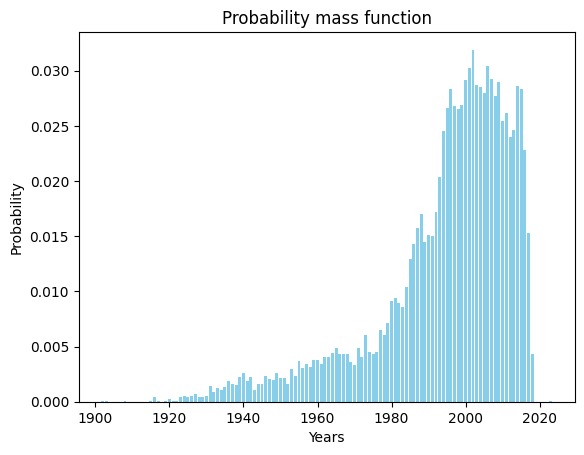

In [47]:
from collections import Counter

years = movies.year
freq = Counter(years)

total = len(years)
probabilities = {k: v / total for k, v in freq.items()}

years_uniques = list(probabilities.keys())
probs = list(probabilities.values())

plt.bar(years_uniques, probs, color='skyblue')
plt.xlabel('Years')
plt.ylabel('Probability')
plt.title('Probability mass function')
plt.show()

Let's try to adjust the data to a specific distribution. We will try to fit our data to a Poisson distribution and, as the sample is large enough, we can try to fit it to different continuous distributions. We will chose the `distribution that minimize the AIC`:
$$
AIC = 2 \cdot k - 2 \cdot \ln(L)
$$
where $k$ is the number of parameters estimated and $L$ is the likelihood function of the best model given the distribution.

In [48]:
import scipy.stats as stats

# List of continuous distributions to try (Poisson is handled separately)
continuous_distributions = [stats.norm, stats.lognorm, stats.gamma, stats.weibull_min]

# Function to calculate AIC
def calculate_aic(ll, k):
    return 2 * k - 2 * ll

results = []

# Fit the Poisson distribution manually
mu_poisson = np.mean(years)
log_likelihood_poisson = np.sum(stats.poisson.logpmf(years, mu_poisson))
aic_poisson = calculate_aic(log_likelihood_poisson, 1)
results.append(("poisson", aic_poisson, (mu_poisson,)))

# Fit the continuous distributions and calculate their AIC
for dist in continuous_distributions:
    # Fit the distribution to the data, fixing loc=0 for Weibull
    if dist == stats.weibull_min:
        params = dist.fit(years, floc=0)
    else:
        params = dist.fit(years)
        
    log_likelihood = np.sum(dist.logpdf(years, *params))
    
    # Number of parameters
    k = len(params)
    
    # Calculate AIC
    aic = calculate_aic(log_likelihood, k)
    
    # Store results
    results.append((dist.name, aic, params))

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results, columns=['Distribution', 'AIC', 'Parameters'])
best_fit = results_df.loc[results_df['AIC'].idxmin()]

# Display the best distribution found
print(results_df)
print("\nBest fit found:")
print(best_fit)


  Distribution           AIC  \
0      poisson  93386.509889   
1         norm  84297.503134   
2      lognorm  84299.543465   
3        gamma  86236.720960   
4  weibull_min  80859.192496   

                                          Parameters  
0                              (1994.6806255787633,)  
1           (1994.6806255787633, 18.496715285842487)  
2  (2.8987357489515093e-06, -6378978.014091806, 6...  
3  (30.709296297494163, 1874.902756254177, 3.8929...  
4        (159.06921682970236, 0, 2002.5180641219051)  

Best fit found:
Distribution                                    weibull_min
AIC                                            80859.192496
Parameters      (159.06921682970236, 0, 2002.5180641219051)
Name: 4, dtype: object


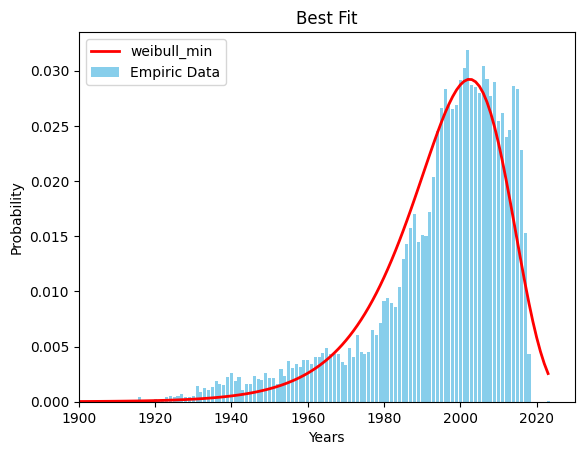

In [49]:
#We graph again the data
plt.bar(years_uniques, probs, color='skyblue', label='Empiric Data')

best_fit_name = best_fit['Distribution']
best_fit_params = best_fit['Parameters']

# Generate density values
discrete_values = np.arange(0, max(years) + 1)

distribution = getattr(stats, best_fit_name)
theoretical_probabilities = distribution.pdf(discrete_values, *best_fit_params)

# Plot the fitted distribution over the empirical data
plt.plot(discrete_values, theoretical_probabilities, color='red', lw=2, label= best_fit_name)

plt.xlabel('Years')
plt.ylabel('Probability')
plt.title('Best Fit')
plt.legend()

plt.xlim(1900,2030)
plt.show()

To verify whether the distribution from which the random sample comes can truly be approximated by a Weibull we should perform a hypothesis test, for example a **$\chi ^2$ test**.


### **Genres analysis**

Let's count the number of genres and their frequency:

In [50]:
genres_freq = Counter([g for movie_genres in movies_df['genres'] for g in movie_genres])

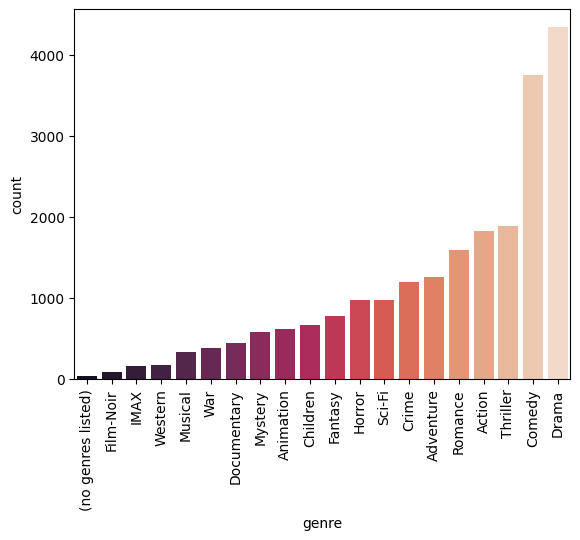

In [51]:
genre_freq_df = pd.DataFrame([genres_freq]).T.reset_index()
genre_freq_df.columns = ['genre', 'count']
sns.barplot(x='genre', y='count', data=genre_freq_df.sort_values(by='count', ascending=True),hue='genre', palette='rocket', dodge=False)
plt.xticks(rotation=90)
plt.show()

## **4. Recommendation Systems**

In this section, once the data has been cleaned and an exploratory analysis has been performed, we can begin to develop machine learning models.

### **Content-based model**

The first model we will develop is a **content-based recommendation system** in which, based on a movie, we will get several recommendations that will be similar to the one we introduced. 

Despite not using the `ratings_df` data set, this recommender has the advantage of being able to deal with **new_movies** that do not have ratings: **cold start problem**.


First we have to convert the `string` data into numbers. `TF-IDF` is a technique that converts text into numerical vectors. It is used to measure the relevance of a word in a string relative to the entire corpus (all the strings).

- **Term Frequency (TF):** Measures how frequently a word appears in a document compared to the total number of words in the document.
  $$
  \text{TF} = \frac{\text{Number of times the word appears in the document}}{\text{Total number of words in the document}}
  $$
  
- **Inverse Document Frequency (IDF):** Measures how common or rare a word is across all documents. If a word appears in many documents, its IDF value will be lower.
  
  $$
  \text{IDF} = \log\left(\frac{\text{Total number of documents}}{\text{Number of documents that contain the word}}\right)
  $$

Hence, 
    $$
    \text{TF - IDF} = \text{TF} \cdot \text{IDF}
    $$


In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies_df['genres_str'])

Now, we have to measure the similarity between two vectors. `Cosine similarity` is a metric that is usually used to measure how similar two documents are, in this case based on the angle between their TF-IDF vectors.

The formula for cosine similarity between two vectors **A** and **B** is:

$$
\text{Cosine Similarity} = \cos(\theta)= \frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\| \|\mathbf{B}\|}
$$


In [53]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

To make the model richer and more personalized, we are going to add two boolean arguments:
- `similar_year`: if this argument is True, the recommender will return movies that were realeased in a time frame similar to the target.
- `mainstream`: if this argument is True, the recommender will return movies that have been very voted.

In [54]:
def filter_by_year(movie_Id, similar_year=True, year_threshold=5):

    # Get the year of the target movie
    movie_year = movies_df.loc[movies_df['movieId'] == movie_Id, 'year'].values[0]
    
    # Get the list of all movie years
    years = movies_df['year'].values
    
    if not similar_year:
        # If not filtering by year, return a mask with all True values
        return np.ones(len(years), dtype=bool)
    else:
        # Filter movies within the year threshold
        return np.abs(years - movie_year) <= year_threshold

In [55]:
def adjust_for_popularity(sim_scores, rating_count, bayesian_average, mainstream=True):
    
    # Normalize the number of ratings and the Bayesian average to the range [0, 1]
    rating_scaled = (rating_count - rating_count.min()) / (rating_count.max() - rating_count.min())
    bayesian_scaled = (bayesian_average - bayesian_average.min()) / (bayesian_average.max() - bayesian_average.min())

    # In adition, this function always boost movies with a high Bayesian average
    sim_scores = sim_scores * (1 + bayesian_scaled)

    # We boost or decrease the influence of 'number of ratings':
    if mainstream:
        return sim_scores * (1 + rating_scaled)
    else:
        return sim_scores * (1 - rating_scaled)  # Reduce influence of popular movies


Finally, we create the final recommender:

In [56]:
def recommend_movies(movie_title, n=5, mainstream=True, Similar_year=False):

    # Get the index of the movie that matches the title
    try:
        movie_index = movies_df[movies_df['title'] == movie_title].index[0]
        movie_Id = movies_df.loc[movie_index, 'movieId']
        movie_year = movies_df.loc[movie_index, 'year']
    except IndexError:
        print(f"Movie '{movie_title}' not found.")
        return []


    # Adjust similarity scores
    sim_scores = adjust_for_popularity(cosine_sim[movie_index], movies_df['rating_count'].values, movies_df['rating_bayesian_mean'].values, mainstream)
    
    # Apply year filtering if similar_year is True
    year_mask = filter_by_year(movie_Id, similar_year = Similar_year)
    sim_scores = sim_scores * year_mask
    
    # Sort movies by similarity score, excluding the movie itself
    movie_indices = sim_scores.argsort()[-(n+1):-1][::-1]  # Get top n movies excluding the target movie itself
    
    print('You have seen:\n ',movies_df.iloc[movie_index])

    return movies_df.iloc[movie_indices]

Let's see some examples:

1. We want 5 recommendations for the movie `Hercules`, similar in year and with many votes:

In [57]:
# We want 5 recommendations for :
recommendation_example_1 = recommend_movies('Hercules', n=5, mainstream=True, Similar_year= True)
recommendation_example_1

You have seen:
  movieId                                                              1566
title                                                            Hercules
genres                  [Adventure, Animation, Children, Comedy, Musical]
year                                                                 1997
genres_str                    Adventure Animation Children Comedy Musical
rating_count                                                           31
rating_mean                                                      3.451613
rating_bayesian_mean                                             3.404163
Name: 1176, dtype: object


,movieId,title,genres,year,genres_str,rating_count,rating_mean,rating_bayesian_mean
322,364,"Lion King, The","[Adventure, Animation, Children, Drama, Musica...",1994,Adventure Animation Children Drama Musical IMAX,172,3.941860,3.903208
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,Adventure Animation Children Comedy Fantasy,215,3.920930,3.890615
3189,4306,Shrek,"[Adventure, Animation, Children, Comedy, Fanta...",2001,Adventure Animation Children Comedy Fantasy Ro...,170,3.867647,3.832834
3563,4886,"Monsters, Inc.","[Adventure, Animation, Children, Comedy, Fantasy]",2001,Adventure Animation Children Comedy Fantasy,132,3.871212,3.826848
3740,5218,Ice Age,"[Adventure, Animation, Children, Comedy]",2002,Adventure Animation Children Comedy,85,3.688235,3.641912


Now we want some movies similar to `Pulp Fiction`. But now we do not mind about the year of release:

In [58]:
recommendation_example_2 = recommend_movies("Pulp Fiction", n=3, mainstream=True, Similar_year= False)
recommendation_example_2

You have seen:
  movieId                                              296
title                                       Pulp Fiction
genres                  [Comedy, Crime, Drama, Thriller]
year                                                1994
genres_str                   Comedy Crime Drama Thriller
rating_count                                         307
rating_mean                                     4.197068
rating_bayesian_mean                            4.166515
Name: 257, dtype: object


,movieId,title,genres,year,genres_str,rating_count,rating_mean,rating_bayesian_mean
277,318,"Shawshank Redemption, The","[Crime, Drama]",1994,Crime Drama,317,4.429022,4.392051
520,608,Fargo,"[Comedy, Crime, Drama, Thriller]",1996,Comedy Crime Drama Thriller,181,4.116022,4.069746
2224,2959,Fight Club,"[Action, Crime, Drama, Thriller]",1999,Action Crime Drama Thriller,218,4.272936,4.227028


Finally, we would like some movies like `Sabrina` but we want they to be quite unknown:

In [59]:
recommendation_example_3 = recommend_movies("Sabrina", n=4, mainstream=False, Similar_year= False)
recommendation_example_3

You have seen:
  movieId                                 7
title                             Sabrina
genres                  [Comedy, Romance]
year                                 1995
genres_str                 Comedy Romance
rating_count                           54
rating_mean                      3.185185
rating_bayesian_mean             3.197625
Name: 6, dtype: object


,movieId,title,genres,year,genres_str,rating_count,rating_mean,rating_bayesian_mean
687,905,It Happened One Night,"[Comedy, Romance]",1934,Comedy Romance,14,4.321429,3.870665
4773,7121,Adam's Rib,"[Comedy, Romance]",1949,Comedy Romance,4,4.750000,3.676338
4384,6442,Belle époque,"[Comedy, Romance]",1992,Comedy Romance,2,5.000000,3.543216
2207,2935,"Lady Eve, The","[Comedy, Romance]",1941,Comedy Romance,8,4.000000,3.583528


## **Collaborative filttering**

First, let's have a look at the sparsity of our matrix:

In [68]:
n_users = ratings_df['userId'].nunique()
n_items = ratings_df['movieId'].nunique()
print('The full rating matrix will have {} elements.'.format(n_users*n_items))
print("The number of ratings is", len(ratings_df))
print('Only {} % of the matrix is filled.'.format(len(ratings_df) / (n_users*n_items) * 100))

The full rating matrix will have 5928590 elements.
The number of ratings is 100830
Only 1.700741660327329 % of the matrix is filled.


Therefore we are working with a really sparse matrix. We base our collaborative filttering model on matrix factorization. `Matrix factorization` consists of decomposing a matrix into several matrices of lower dimension (greatly **reducing the complexity**) and to find **latent relationships**. In this project we are using SVD descomposition

### Singular Value Decomposition (SVD)

Singular Value Decomposition (SVD) is a matrix factorization technique that decomposes a matrix $A$ into three distinct matrices:

$$
A = U \Sigma V^T
$$

- **$U$**: An orthogonal matrix ($U \cdot U^T = I$) whose columns are the left singular vectors of $A$.
- **$\Sigma$**: A diagonal matrix containing the singular values of $A$ sorted from bigger to lower.
- **$V^T$**: The transpose of an orthogonal matrix $V$, whose columns are the right singular vectors of $A$.

### Truncated Singular Value Decomposition (Truncated SVD)

Truncated Singular Value Decomposition (Truncated SVD) reduces the dimensionality of a matrix by keeping only the most significant components.

Truncated SVD approximates a matrix $ A $ by using only the top $ k $ singular values, reducing computational complexity while retaining the most significant features of the data.

$$
A \approx U_k \Sigma_k V_k^T
$$

where `k` is the number of components to retain.

- **$ U_k $**: An orthogonal matrix with the first $ k $ columns of $ U $.
- **$ \Sigma_k $**: A diagonal matrix with the first $ k $ largest singular values of $ \Sigma $.
- **$ V_k^T $**: The transpose of an orthogonal matrix with the first $ k $ rows of $ V^T $.

In [84]:
#First we split the data into train and test:
from sklearn.model_selection import train_test_split
X_train_index, X_test_index = train_test_split(ratings_df.index, test_size= 0.5, random_state=48) #we split the index. We use 0.5 because performs better

X_train = ratings_df.copy()
X_test = ratings_df.copy()

#now we replace the values that are not in the indexes by NaN in order to do not loss dimensions
X_train['rating'] = X_train.apply(lambda x: np.nan if x.name in X_train_index else x.rating, axis=1) 
X_test['rating'] = X_test.apply(lambda x: np.nan if x.name in X_test_index else x.rating, axis=1)


# We create the utility matrix (interactions between users and movies) for the train set
utility_matrix_train = X_train.pivot_table(index='userId', columns='movieId', values='rating', dropna=False)

from sklearn.impute import SimpleImputer
# Now we define a imputer that is expected to fill the null values of each movie by its mean rating (we could use bayesian_mean)
imputer = SimpleImputer(strategy='mean')


#NOTE: As the data set is small, we probably have many movies without any rating in the train set. For that reason:
# We identify the columns that have only NaN values:
all_nan_columns = utility_matrix_train.columns[utility_matrix_train.isna().all()]

# We fill only those columns with a default value (ex: 3 because we have seen many of the ratings usually are positive (we could chose mean(0.5,5))
fill_value = 3
utility_matrix_train_filled = utility_matrix_train.copy()
utility_matrix_train_filled[all_nan_columns] = utility_matrix_train_filled[all_nan_columns].fillna(fill_value)

# Now we can use the 'imputer'
matrix_imputed_train = imputer.fit_transform(utility_matrix_train_filled)

from sklearn.decomposition import TruncatedSVD
## We can define the model:
svd_train = TruncatedSVD(n_components=20, n_iter=10, random_state=3) #we are only considering the first 20 singular values

Q_train = svd_train.fit_transform(matrix_imputed_train)

# We reconstruct the matrix
approx_matrix_train = np.dot(Q_train, svd_train.components_)

#Convert it to Dataframe
predicted_ratings_train = pd.DataFrame(approx_matrix_train, index=utility_matrix_train.index, columns=utility_matrix_train.columns)

Let's test our model:

In [85]:
#We create the utility matrix for the test set:
utility_matrix_test = X_test.pivot_table(index='userId', columns='movieId', values='rating', dropna=False)

#We take the convert the matrix to a unique array
real_flat_test = utility_matrix_test.values.flatten()

#Create a mask to obtain the not null values:
mask_test = ~np.isnan(real_flat_test)
real_flat_masked_test = real_flat_test[mask_test]

#We take the predictions made by the train set and convert them into an array
pred_flat_train = predicted_ratings_train.values.flatten()
pred_flat_masked_test = pred_flat_train[mask_test]

# Now we calculate the RMSE for the test set:
errors = real_flat_masked_test - pred_flat_masked_test
squared_errors = errors ** 2
mean_squared_error_manual = np.mean(squared_errors)
rmse_manual = np.sqrt(mean_squared_error_manual)

print('The RMSE using TruncatedSVD is {} in the test set.'.format(rmse_manual))

The RMSE using TruncatedSVD is 0.9841734697764402 in the test set.


As the ratings are on a scale of 0.5 to 5, an RMSE of less than 1 is usually reasonably good.

We could also use the library `surprise`, that is very complete:

In [86]:
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import accuracy


reader = Reader(rating_scale=(0.5, 5.0))

data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

trainset, testset = train_test_split(data, test_size=0.25)

algo = SVD()

algo.fit(trainset)

predictions_test = algo.test(testset)

print('Using the library "surprise" we obtain a RMSE of {} in the test set.'.format(accuracy.rmse(predictions_test)))

RMSE: 0.8742
Using the library "surprise" we obtain a RMSE of 0.8742236919441985 in the test set.


## **Conclusion**

As we have been able to observe throughout this study, the `MovieLens dataset` is highly rich in information, consistent with the data and suitable for study and practice.

We have had the opportunity to make an exhaustive study of the `movies_df` and `ratings_df` data sets, cleaning the data and improving both matrices with new features. From the developed recommendation systems, we have been able to obtain both predictive models in terms of the score, as well as recommendations based in a given movie (dealing with the 'cold start problem').

**Highlights of the project:**

- Development of a scraping tool to obtain information about movies.

- Customization of a 'content-based' model by adding parameters and features.
- Compression of the SVD matrix decomposition.

**Future models and studies:**

- Perform a chi-squared test (statistical hypothesis test) to verify whether the distribution from which the years in the data_set came could be approximated by a weibull_min.
- Develop more complex models that incorporate neural networks.
- Use the complete Movie_Lens_100K data set.